# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [116]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

# Load files

In [118]:
date_min = '2048-01-01'
date_max = '2062-12-31'

In [119]:
# lon_min = -13.5
# lon_max = 6.5
# lat_min = 32
# lat_max = 49
lon_min=-10
lon_max=4
lat_min=35.5
lat_max=44

## Format functions

In [120]:
def format_LMDZ_MO(filename, name, color=None, date_min=None, date_max=None):
    """
    Format the LMDZ-MO output for plotting.
    """
    ds = xr.open_mfdataset(filename)
    ds.attrs['name'] = name
    ds.attrs['plot_color'] = color if color else 'blue'

    rename_dict = {'time_counter':'time'}
    ds = ds.rename(rename_dict)

    ds = ds.coarsen(lat=2, lon=3, boundary='trim').mean()
    
    #restrict
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    else:
        print('No domain restriction applied, missing lon_min, lon_max, lat_min, lat_max')
    if date_min is not None and date_max is not None:
        ds = ds.sel(time=slice(date_min, date_max))
    else:
        print('No date restriction applied, missing date_min, date_max')

    #edit and convert units
    ds['evap'] = ds['evap'] *3600 * 24
    ds['evap'].attrs['units'] = 'mm/d'
    ds['evap'].attrs['name'] = 'ET'

    ds['precip'] = ds['precip'] *3600 * 24
    ds['precip'].attrs['units'] = 'mm/d'
    ds['precip'].attrs['name'] = 'Precipitation'

    ds['t2m'] = ds['t2m'] - 273.15
    ds['t2m'].attrs['units'] = '°C'
    ds['t2m'].attrs['name'] = '2-m temperature'

    ds['fluxsens']= -ds['sens']
    ds['fluxsens'].attrs['units'] = 'W/m²'
    ds['fluxsens'].attrs['name'] = 'Sensible heat flux'

    ds['netrad'] = ds['LWdnSFC'] - ds['LWupSFC'] + ds['SWdnSFC'] - ds['SWupSFC']
    ds['netrad'].attrs['name'] = 'Surface net radiation'
    ds['netrad'].attrs['units'] = 'W/m²'

    ds['SWnetSFC'] = ds['SWdnSFC'] - ds['SWupSFC']
    ds['SWnetSFC'].attrs['name'] = 'Surface net SW'
    ds['SWnetSFC'].attrs['units'] = 'W/m²'

    ds['LWnetSFC'] = ds['LWdnSFC'] - ds['LWupSFC']
    ds['LWnetSFC'].attrs['name'] = 'Surface net LW'
    ds['LWnetSFC'].attrs['units'] = 'W/m²'

    ds['P - E'] = ds['precip'] - ds['evap']
    ds['P - E'].attrs['units'] = 'mm/d'

    #add names and units
    ds['SWdnSFC'].attrs['name'] = 'Surface SW down'
    ds['SWdnSFC'].attrs['units'] = 'W/m²'
    ds['LWdnSFC'].attrs['name'] = 'Surface LW down'
    ds['LWdnSFC'].attrs['units'] = 'W/m²'

    ds['cldt'].attrs['name'] = 'Total cloud cover'
    ds['cldt'].attrs['units'] = '%'

    ds['cldl'] = ds['cldl'] * 100  # Convert to percentage
    ds['cldl'].attrs['name'] = 'Low cloud cover'
    ds['cldl'].attrs['units'] = '%'

    ds['cldm'] = ds['cldm'] * 100  # Convert to percentage
    ds['cldm'].attrs['name'] = 'Medium cloud cover'
    ds['cldm'].attrs['units'] = '%'

    ds['cldh'] = ds['cldh'] * 100  # Convert to percentage
    ds['cldh'].attrs['name'] = 'High cloud cover'
    ds['cldh'].attrs['units'] = '%'

    return ds

In [121]:
def format_ORC_MO(filename, name, color=None, date_min=None, date_max=None):
    """
    Format the ORC output for plotting.
    """
    ds = xr.open_mfdataset(filename)
    ds.attrs['name'] = name
    ds.attrs['plot_color'] = color if color else 'blue'

    rename_dict = {'time_counter':'time'}
    ds = ds.rename(rename_dict)

    ds = ds.coarsen(lat=2, lon=3, boundary='trim').mean()

    #restrict
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    else:
        print('No domain restriction applied, missing lon_min, lon_max, lat_min, lat_max')
    if date_min is not None and date_max is not None:
        ds = ds.sel(time=slice(date_min, date_max))
    else:
        print('No date restriction applied, missing date_min, date_max')


    #edit units and names
    if 'streamr' in ds:
        ds['streamr'].attrs['units'] = 'kg/m²'
        ds['streamr'].attrs['long_name'] = 'River reservoir volume'
    if 'slowr' in ds:
        ds['slowr'].attrs['units'] = 'kg/m²'
        ds['slowr'].attrs['long_name'] = 'GW reservoir volume'
    if 'fastr' in ds:
        ds['fastr'].attrs['units'] = 'kg/m²'
        ds['fastr'].attrs['long_name'] = 'Overland reservoir volume'

    if color is not None:
        ds.attrs['plot_color'] = color
    
    if 'coastalflow' in ds and 'riverflow' in ds:
        ds['coast_and_river'] = ds['coastalflow'] + ds['riverflow']
        ds['coast_and_river'].attrs['units'] = 'm³/s'
        ds['coast_and_river'].attrs['long_name'] = 'Coastal and river flow'

    return ds

## LMDZ

In [122]:
future_noirr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_noirr'
future_irr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/future_irr'

In [123]:
filename = '{}/*2049*histmth.nc'.format(future_noirr_dir)
color = 'red'
lmdz_noirr = format_LMDZ_MO(filename, 'no_irr', color=color, date_min=date_min, date_max=date_max)
lmdz_noirr

<xarray.Dataset> Size: 346MB
Dimensions:               (time: 12, axis_nbounds: 2, klevp1: 80, bnds: 2,
                           klev: 79, lat: 42, lon: 44, presnivs: 79,
                           presinter: 80)
Coordinates:
  * klevp1                (klevp1) float64 640B 1.0 2.0 3.0 ... 78.0 79.0 80.0
  * bnds                  (bnds) float32 8B 1.0 2.0
  * klev                  (klev) float64 632B 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * presnivs              (presnivs) float32 316B 1.012e+05 1.009e+05 ... 1.483
  * presinter             (presinter) float32 320B 1.013e+05 1.011e+05 ... 0.0
    time_instant          (time) datetime64[ns] 96B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 96B 2049-01-16T12:00:00 ... 2...
    time_centered         (time) datetime64[ns] 96B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/332)
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Ahyb                  (klevp1) float32 320B dask.array<chunksize=(80,), meta=np.ndarray>
    Ahyb_bounds           (bnds, klevp1) float32 640B dask.array<chunksize=(2, 80), meta=np.ndarray>
    Bhyb                  (klevp1) float32 320B dask.array<chunksize=(80,), meta=np.ndarray>
    ...                    ...
    rld                   (time, presinter, lat, lon) float32 7MB dask.array<chunksize=(1, 80, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    netrad                (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    LWnetSFC              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-May-30 14:23:01 GMT
    uuid:         c5f807b1-fec3-4be4-bdff-a9b6f9c54bfc
    history:      Wed Jun  4 23:57:33 2025: ncrcat -C --buffer_size 838860800...
    NCO:          netCDF Operators version 5.0.1 (Homepage = http://nco.sf.ne...
    plot_color:   red

In [124]:
filename = '{}/*2053*histmth.nc'.format(future_irr_dir)
color = 'blue'
lmdz_irr = format_LMDZ_MO(filename, 'no_irr', color=color, date_min=date_min, date_max=date_max)
lmdz_irr

<xarray.Dataset> Size: 346MB
Dimensions:               (time: 12, axis_nbounds: 2, klevp1: 80, bnds: 2,
                           klev: 79, lat: 42, lon: 44, presnivs: 79,
                           presinter: 80)
Coordinates:
  * klevp1                (klevp1) float64 640B 1.0 2.0 3.0 ... 78.0 79.0 80.0
  * bnds                  (bnds) float32 8B 1.0 2.0
  * klev                  (klev) float64 632B 1.0 2.0 3.0 4.0 ... 77.0 78.0 79.0
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * presnivs              (presnivs) float32 316B 1.012e+05 1.009e+05 ... 1.483
  * presinter             (presinter) float32 320B 1.013e+05 1.011e+05 ... 0.0
    time_instant          (time) datetime64[ns] 96B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 96B 2053-01-16T12:00:00 ... 2...
    time_centered         (time) datetime64[ns] 96B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/332)
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Ahyb                  (klevp1) float32 320B dask.array<chunksize=(80,), meta=np.ndarray>
    Ahyb_bounds           (bnds, klevp1) float32 640B dask.array<chunksize=(2, 80), meta=np.ndarray>
    Bhyb                  (klevp1) float32 320B dask.array<chunksize=(80,), meta=np.ndarray>
    ...                    ...
    rld                   (time, presinter, lat, lon) float32 7MB dask.array<chunksize=(1, 80, 42, 44), meta=np.ndarray>
    fluxsens              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    netrad                (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    SWnetSFC              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    LWnetSFC              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Jul-23 18:23:51 GMT
    uuid:         9cf40b99-a699-497b-83ef-d825d292e7ca
    history:      Thu Jul 24 06:30:36 2025: ncrcat -C --buffer_size 838860800...
    NCO:          netCDF Operators version 5.0.1 (Homepage = http://nco.sf.ne...
    plot_color:   blue

## ORC

In [125]:
filename = '{}/*2060*sechiba_history.nc'.format(future_noirr_dir)
color = 'red'
orc_noirr = format_ORC_MO(filename, 'no_irr', color=color, date_min=date_min, date_max=date_max)
orc_noirr

<xarray.Dataset> Size: 26MB
Dimensions:               (time: 12, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 96B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 96B 2060-01-16T12:00:00 ... 2...
Dimensions without coordinates: axis_nbounds
Data variables: (12/78)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (lat, lon) float32 7kB dask.array<chunksize=(42, 44), meta=np.ndarray>
    Contfrac              (lat, lon) float32 7kB dask.array<chunksize=(42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    aei_sw                (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    RootDist              (solay, lat, lon) float32 81kB dask.array<chunksize=(11, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 89kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 266kB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 266kB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Jul-04 03:52:46 GMT
    uuid:         b66b2aba-8495-446c-a9eb-5186d2979352
    history:      Fri Jul  4 16:11:41 2025: ncrcat -C --buffer_size 838860800...
    NCO:          netCDF Operators version 5.0.1 (Homepage = http://nco.sf.ne...
    plot_color:   red

In [126]:
filename = '{}/*sechiba_history.nc'.format(future_irr_dir)
color = 'blue'
orc_irr = format_ORC_MO(filename, 'no_irr', color=color, date_min=date_min, date_max=date_max)
orc_irr

<xarray.Dataset> Size: 224MB
Dimensions:               (time: 96, axis_nbounds: 2, lat: 42, lon: 44,
                           veget: 15, soiltyp: 3, solth: 18, nobio: 1,
                           solay: 11, snowlev: 3)
Coordinates:
  * lat                   (lat) float32 168B 35.68 35.88 36.08 ... 43.72 43.92
  * lon                   (lon) float32 176B -9.729 -9.412 ... 3.568 3.884
  * veget                 (veget) float32 60B 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp               (soiltyp) float32 12B 1.0 2.0 3.0
  * solth                 (solth) float32 72B 0.0004888 0.001955 ... 33.53 65.56
  * nobio                 (nobio) float32 4B 1.0
  * solay                 (solay) float32 44B 0.0 0.001955 ... 0.999 2.0
  * snowlev               (snowlev) float32 12B 1.0 2.0 3.0
    time_centered         (time) datetime64[ns] 768B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 768B 2048-01-16T12:00:00 ... ...
Dimensions without coordinates: axis_nbounds
Data variables: (12/88)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                 (time, lat, lon) float32 710kB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    Contfrac              (time, lat, lon) float32 710kB dask.array<chunksize=(12, 42, 44), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    ...                    ...
    Count_failure_fast    (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    Count_failure_stre    (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowmelt              (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    tot_melt              (time, lat, lon) float32 710kB dask.array<chunksize=(1, 42, 44), meta=np.ndarray>
    snowdz                (time, snowlev, lat, lon) float32 2MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
    humtot_soil           (time, soiltyp, lat, lon) float32 2MB dask.array<chunksize=(1, 3, 42, 44), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2025-Jul-17 02:40:07 GMT
    uuid:         4c0e3a8b-38e6-4677-b6a0-1dfeeb3fec8d
    history:      Thu Jul 17 14:50:40 2025: ncrcat -C --buffer_size 838860800...
    NCO:          netCDF Operators version 5.0.1 (Homepage = http://nco.sf.ne...
    plot_color:   blue

## Masks and interp

In [127]:
#define masks
con_mask=lmdz_irr['fract_ter']>0.95
ip_mask=polygon_to_mask(lmdz_irr, iberian_peninsula)

# cont_lmdz_noirr=lmdz_noirr.where(con_mask)
# cont_lmdz_irr=lmdz_irr.where(con_mask)
# cont_orc_noirr=orc_noirr.where(con_mask)
# cont_orc_irr=orc_irr.where(con_mask)

ip_lmdz_noirr = lmdz_noirr.where(ip_mask, drop=False).where(con_mask)
ip_lmdz_irr = lmdz_irr.where(ip_mask, drop=False).where(con_mask)
ip_orc_noirr = orc_noirr.where(ip_mask, drop=False).where(con_mask)
ip_orc_irr = orc_irr.where(ip_mask, drop=False).where(con_mask)


# Tests

## Maps

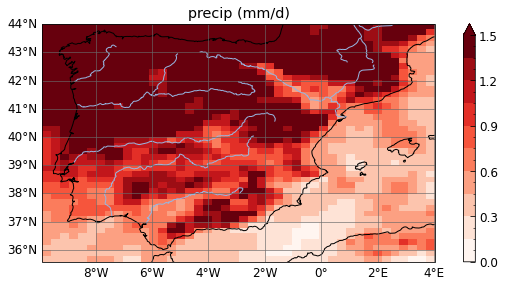

In [128]:
#Display map of var for ds
var='precip'
ds=lmdz_irr
color_map=reds
min_value=0
max_value=1.5
# min_value, max_value = None, None

map_ave(ds, var, cmap=color_map, vmin=min_value, vmax=max_value, hex=False)

No significance mask applied


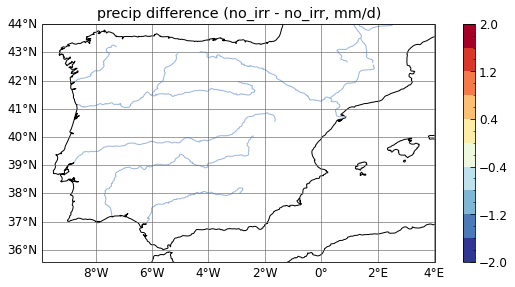

In [129]:
#Diff map
var='precip'
ds1=lmdz_noirr
ds2=lmdz_irr
max_value= 2
min_value=-2
# max_value, min_value = None, None

color_map=emb

# title='Evapotranspiration bias (mm/d, {} - {})'.format( ds1.attrs['name'], ds2.attrs['name'])
title=None

map_diff_ave(ds1, ds2, var, vmin=min_value, vmax=max_value, title=title, cmap=color_map, hex=False, sig=False)

# diff=ds1[var]-ds2[var]
# title='{} bias, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])
# map_seasons(diff, cmap=color_map,  vmin=min_value, vmax=max_value, title=title, hex=False)

In [130]:
#map for 4 seasons
var='precip'
ds1=cont_sim
ds2=cont_era
max_value=2
min_value=None
# min_value=-max_value

diff=ds1[var]-ds2[var]
title='{} bias, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])
plotvar=diff

# plotvar=ds1[var]
# title='P-E (mm/d, {})'.format(ds1.attrs['name'])

map_seasons(plotvar, cmap=emb, vmax=max_value, title=title, hex=False)

NameError: name 'cont_sim' is not defined

In [ ]:
#Display map of var for ds on restricted area
var='precip'
ds = lmdz_2000_80_era
latmin=42.2
latmax=43.5
lonmin=-2
lonmax=3
vmax= 3
vmin=-3

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True).where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True).where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time') -era[var].mean(dim='time')
map_plotvar(plotvar, cmap=emb, vmin=vmin, vmax=vmax, title=ds.attrs['name'])

In [ ]:
#Relative diff map
var='precip'
max_value=None
ds1=cont_fluxcom
ds2=ip_fluxcom
# plt.title('Gross primary production relative difference (%)')
map_rel_diff_ave(ds1, ds2, var, vmax=max_value)

## Time series

TypeError: No numeric data to plot.

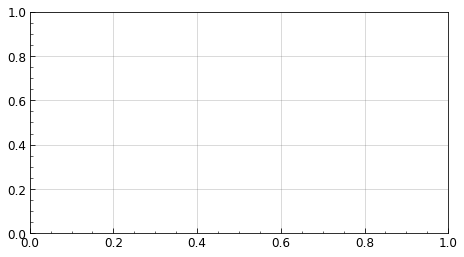

In [133]:
var='evap'

ds1=lmdz_noirr
ds2=lmdz_irr

ds_list=[ds1]#, ds2]

year_min=2048
year_max=2062
time_series_ave(ds_list, var, title='{} {}'.format(var, ds1[var].attrs['units']),
                ds_colors=True)
# seasonal_cycle_ave(ds_list, var, year_max=year_max, 
#                    title='Seasonal cycle of {} ({})'.format(var, ds1[var].attrs['units']),
#                    ds_colors=True)

# Figures